<a href="https://colab.research.google.com/github/Reyhaneh2001/adult_income_prediction/blob/main/PredictingAdultIncome.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install xgboost shap
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import shap

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, roc_curve

from xgboost import XGBClassifier, plot_importance

In [ ]:
# Load and explore dataset
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data"
columns = ['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status',
           'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss',
           'hours-per-week', 'native-country', 'income']

df = pd.read_csv(url, header=None, names=columns, na_values=' ?')

print(df.info())
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             32561 non-null  int64 
 1   workclass       30725 non-null  object
 2   fnlwgt          32561 non-null  int64 
 3   education       32561 non-null  object
 4   education-num   32561 non-null  int64 
 5   marital-status  32561 non-null  object
 6   occupation      30718 non-null  object
 7   relationship    32561 non-null  object
 8   race            32561 non-null  object
 9   sex             32561 non-null  object
 10  capital-gain    32561 non-null  int64 
 11  capital-loss    32561 non-null  int64 
 12  hours-per-week  32561 non-null  int64 
 13  native-country  31978 non-null  object
 14  income          32561 non-null  object
dtypes: int64(6), object(9)
memory usage: 3.7+ MB
None


,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


# **Data cleaning and preprocessing**

In [ ]:
df.isnull().sum()

# Drop missing
df.dropna(inplace=True)

# Strip whitespace from string columns
df = df.applymap(lambda x: x.strip() if type(x)==str else x)

df['income'] = df['income'].map({'>50K': 1, '<=50K': 0})

# Identify categorical and numeric columns
cat_cols = df.select_dtypes(include='object').columns
num_cols = df.select_dtypes(include='number').columns.drop('income')

# Label encode categorical features
le = LabelEncoder()
df[cat_cols] = df[cat_cols].apply(le.fit_transform)

# Feature matrix and target
X = df.drop('income', axis=1)
y = df['income']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize numerical columns
scaler = StandardScaler()
X_train[num_cols] = scaler.fit_transform(X_train[num_cols])
X_test[num_cols] = scaler.transform(X_test[num_cols])

<ipython-input-3-cefe4efa5470>:7: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(lambda x: x.strip() if type(x)==str else x)


# **EDA with visualization**

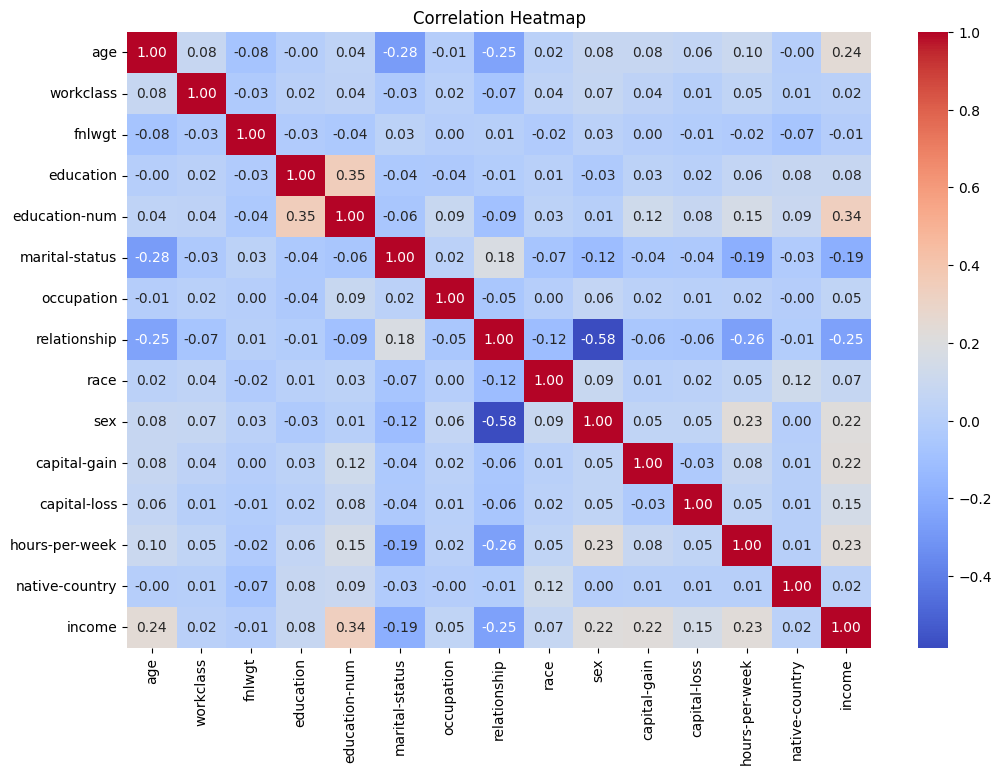

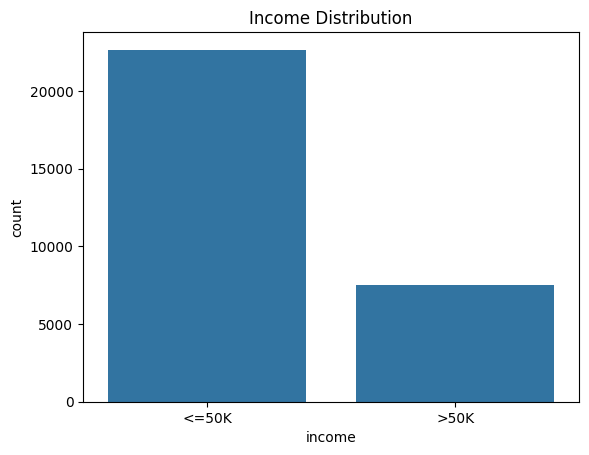

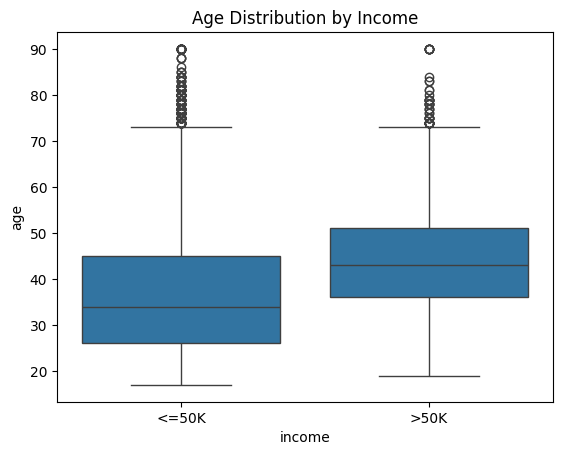

In [ ]:
# Correlation heatmap
plt.figure(figsize=(12,8))
sns.heatmap(df.corr(), annot=True, fmt='.2f', cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

# Income distribution
sns.countplot(x='income', data=df)
plt.title("Income Distribution")
plt.xticks([0, 1], ['<=50K', '>50K'])
plt.show()

# Age vs Income
sns.boxplot(x='income', y='age', data=df)
plt.title('Age Distribution by Income')
plt.xticks([0, 1], ['<=50K', '>50K'])
plt.show()

# **Training Model**

In [ ]:
xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
xgb.fit(X_train, y_train)

y_pred = xgb.predict(X_test)

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [17:55:22] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


# **Evaluation**

Accuracy: 0.8695508039118184
Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.93      0.91      4503
           1       0.77      0.69      0.73      1530

    accuracy                           0.87      6033
   macro avg       0.83      0.81      0.82      6033
weighted avg       0.87      0.87      0.87      6033



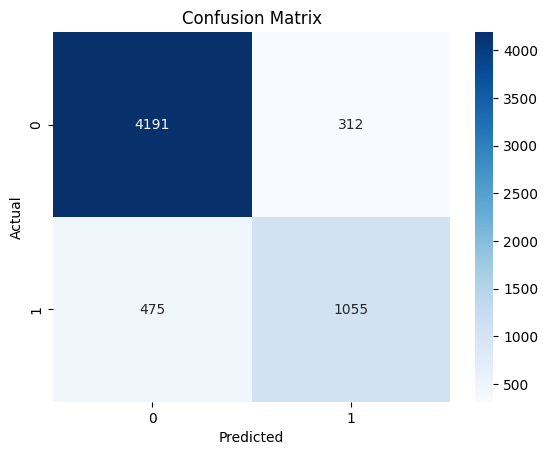

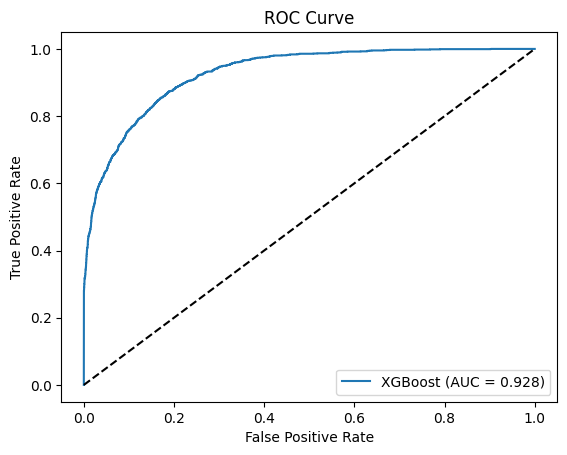

In [ ]:
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

# Confusion Matrix
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

# ROC-AUC
y_proba = xgb.predict_proba(X_test)[:,1]
fpr, tpr, _ = roc_curve(y_test, y_proba)
plt.plot(fpr, tpr, label='XGBoost (AUC = %.3f)' % roc_auc_score(y_test, y_proba))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()


# **Hyperparameter tuning**

In [ ]:
params = {
    'max_depth': [3, 5],
    'learning_rate': [0.01, 0.1],
    'n_estimators': [100, 200],
    'subsample': [0.8, 1],
}

grid = GridSearchCV(XGBClassifier(use_label_encoder=False, eval_metric='logloss'),
                    param_grid=params, cv=3, scoring='f1', verbose=1)
grid.fit(X_train, y_train)

print("Best parameters:", grid.best_params_)

# Retrain best model
best_model = grid.best_estimator_
y_pred_best = best_model.predict(X_test)

print("Accuracy after tuning:", accuracy_score(y_test, y_pred_best))
print("F1 Score after tuning:", classification_report(y_test, y_pred_best))

Fitting 3 folds for each of 16 candidates, totalling 48 fits


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [17:57:01] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [17:57:06] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [17:57:09] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [17:57:13] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [17:57:14] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_e

Best parameters: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 200, 'subsample': 1}
Accuracy after tuning: 0.8731974142217802
F1 Score after tuning:               precision    recall  f1-score   support

           0       0.90      0.94      0.92      4503
           1       0.79      0.68      0.73      1530

    accuracy                           0.87      6033
   macro avg       0.84      0.81      0.82      6033
weighted avg       0.87      0.87      0.87      6033



# **Feature Importance and Explainability using shap values**

<Figure size 1000x600 with 0 Axes>

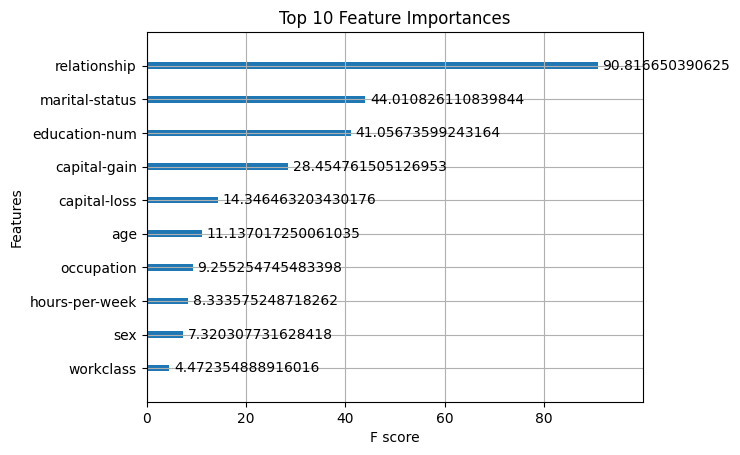

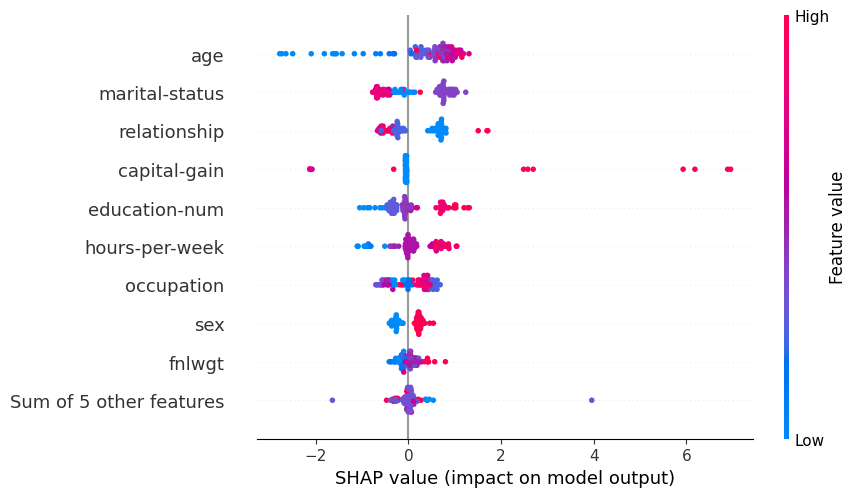

In [ ]:
# Plot feature importance
plt.figure(figsize=(10,6))
plot_importance(best_model, importance_type='gain', max_num_features=10)
plt.title("Top 10 Feature Importances")
plt.show()

# SHAP values for explainability
explainer = shap.Explainer(best_model, X_train)
shap_values = explainer(X_test[:100])

shap.plots.beeswarm(shap_values)